## RQ 1:  How do weather conditions (temperature, humidity, wind speed, etc.) influence bike rental demand? 

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.families import Poisson, NegativeBinomial
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the dataset with appropriate encoding
file_path = "SeoulBikeData.csv"  # Adjust path if needed
df = pd.read_csv(file_path, encoding='latin1')

# Display data info and the first few rows
print(df.info())
print(df.head())

df.columns = df.columns.str.strip()
df = df.rename(columns={"Rented Bike Count": "RentedBikeCount"})

# Drop non-weather and non-continuous features
drop_cols = ["Date", "Functioning Day", "Holiday", "Hour"]
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Drop any 'Seasons' dummies or labels
df = df[[col for col in df.columns if not col.startswith("Seasons")]]

# Separate target and predictors
y = df["RentedBikeCount"]
X_all = df.drop(columns=["RentedBikeCount"])
# All features are continuous → use as spline features
spline_cols = list(X_all.columns)

# Standardize spline features
scaler = StandardScaler()
X_spline_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_spline_scaled, y, test_size=0.2, random_state=583)

# Clip test data to avoid extrapolation
X_test_clipped = X_test.copy()
for col in X_all.columns:
    X_test_clipped[col] = X_test[col].clip(X_train[col].min(), X_train[col].max())

# Prepare inputs
X_train_smooth = X_train.reset_index(drop=True)
X_test_smooth = X_test_clipped.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Use intercept-only linear part
X_train_lin_simple = pd.DataFrame(np.ones((len(X_train_smooth), 1)), columns=["Intercept"])
X_test_lin_simple = pd.DataFrame(np.ones((len(X_test_smooth), 1)), columns=["Intercept"])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

### Random Forest

In [10]:
#RF code

# Prepare data: already cleaned to contain weather-related features only
# Use the same standardized data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_spline_scaled, y, test_size=0.2, random_state=583
)

# Fit a random forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=583)
rf_model.fit(X_train_rf, y_train_rf)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)

# Variable importance
feature_importance = pd.DataFrame({
    "Feature": X_train_rf.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
r2__rf = r2_score(y_test_rf, y_pred_rf)

print(f"Random Forest Test RMSE: {rmse_rf:.2f}")
print(f"Random Forest Test MAE : {mae_rf:.2f}")
print(f"Random Forest Test R² : {r2__rf:.2f}")

Random Forest Test RMSE: 429.04
Random Forest Test MAE : 278.43
Random Forest Test R² : 0.58


### Grid Search CV

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 14],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create RF model
rf_base = RandomForestRegressor(random_state=583)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search on training data
grid_search.fit(X_train_rf, y_train_rf)

# Best model
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model
y_pred_best_rf = best_rf_model.predict(X_test_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test_rf, y_pred_best_rf)
r2_best_rf = r2_score(y_test_rf, y_pred_best_rf)

formatted_output = {
    "Best Parameters": best_params,
    "Test RMSE": round(rmse_best_rf, 2),
    "Test MAE": round(mae_best_rf, 2),
    "Test R²": round(r2_best_rf, 4)
}
formatted_output


Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'Best Parameters': {'max_depth': 14,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 300},
 'Test RMSE': 426.14,
 'Test MAE': 276.96,
 'Test R²': 0.588}

### Feature importance

In [4]:
feature_importance

,Feature,Importance
0,Temperature(°C),0.393636
1,Humidity(%),0.199012
5,Solar Radiation (MJ/m2),0.124165
4,Dew point temperature(°C),0.098206
2,Wind speed (m/s),0.096402
3,Visibility (10m),0.071744
6,Rainfall(mm),0.016247
7,Snowfall (cm),0.000588


### GAM approach, fitting a simple model with basic settings

In [5]:
# Fit GAM
print(f'spline_cols: {spline_cols}')
bs = BSplines(X_train_smooth, df=[4]*len(spline_cols), degree=[2]*len(spline_cols))
gam = GLMGam(y_train, exog=X_train_lin_simple, smoother=bs, family=NegativeBinomial())
gam_result = gam.fit()

# Predict and evaluate
y_pred = gam_result.predict(exog=X_test_lin_simple, exog_smooth=X_test_smooth)
mse = mean_squared_error(y_test[:len(y_pred)], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test[:len(y_pred)], y_pred)

# Deviance metrics
residual_deviance = gam_result.deviance
null_deviance = gam_result.null_deviance
explained_deviance = 1 - (residual_deviance / null_deviance)

# Pseudo R^2 (McFadden)
loglik_full = gam_result.llf
loglik_null = gam_result.llnull
pseudo_r2 = 1 - (loglik_full / loglik_null)

# Print model summary and evaluation metrics
print(gam_result.summary())
print("\n--- Evaluation Metrics ---")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Residual Deviance: {residual_deviance:.2f}")
print(f"Null Deviance: {null_deviance:.2f}")
print(f"Explained Deviance: {explained_deviance:.4f}")
print(f"Pseudo R² (McFadden): {pseudo_r2:.4f}")


spline_cols: ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']


C:\DATA_583\DATA583\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:        RentedBikeCount   No. Observations:                 7008
Model:                         GLMGam   Df Residuals:                  6985.60
Model Family:        NegativeBinomial   Df Model:                        21.40
Link Function:                    Log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -51028.
Date:                Sun, 23 Mar 2025   Deviance:                       5911.5
Time:                        20:35:33   Pearson chi2:                 3.35e+03
No. Iterations:                    31   Pseudo R-squ. (CS):             0.4220
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

First try, keep things as low as possible, including all params (df, degree)
maybe also drop humidity

### Tune GAM and output best model

In [6]:
# Tuning grid
df_grid = [4, 6, 8, 10]
alpha_grid = [0.5, 1, 2, 5, 10, 15, 20]
degree_grid = [2, 3]
results = []

# Poisson models
for df_val in df_grid:
    for deg_val in degree_grid:
        try:
            bs = BSplines(X_train_smooth, df=[df_val]*X_train_smooth.shape[1], degree=[deg_val]*X_train_smooth.shape[1])
            gam = GLMGam(y_train, exog=X_train_lin_simple, smoother=bs, family=Poisson())
            result = gam.fit()
            y_pred = result.predict(exog=X_test_lin_simple, exog_smooth=X_test_smooth)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            aic = result.aic
            deviance = result.deviance
            null_deviance = result.null_deviance
            explained_deviance = 1 - (deviance / null_deviance)
            pseudo_r2 = 1 - (result.llf / result.llnull)

            results.append({
                "Family": "Poisson",
                "df": df_val,
                "Degree": deg_val,
                "Alpha": None,
                "RMSE": rmse,
                "MAE": mae,
                "AIC": aic,
                "Deviance": deviance,
                "Null Deviance": null_deviance,
                "Explained Deviance": explained_deviance,
                "Pseudo R^2 (McF)": pseudo_r2
            })
        except Exception as e:
            results.append({
                "Family": "Poisson",
                "df": df_val,
                "Degree": deg_val,
                "Alpha": None,
                "RMSE": np.nan,
                "MAE": np.nan,
                "AIC": np.nan,
                "Deviance": np.nan,
                "Null Deviance": np.nan,
                "Explained Deviance": np.nan,
                "Pseudo R^2 (McF)": np.nan,
                "Error": str(e)
            })

# Negative Binomial models
for alpha_val in alpha_grid:
    for df_val in df_grid:
        for deg_val in degree_grid:
            try:
                fam = NegativeBinomial(alpha=alpha_val)
                bs = BSplines(X_train_smooth, df=[df_val]*X_train_smooth.shape[1], degree=[deg_val]*X_train_smooth.shape[1])
                gam = GLMGam(y_train, exog=X_train_lin_simple, smoother=bs, family=fam)
                result = gam.fit()
                y_pred = result.predict(exog=X_test_lin_simple, exog_smooth=X_test_smooth)

                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                aic = result.aic
                deviance = result.deviance
                null_deviance = result.null_deviance
                explained_deviance = 1 - (deviance / null_deviance)
                pseudo_r2 = 1 - (result.llf / result.llnull)

                results.append({
                    "Family": "NegativeBinomial",
                    "df": df_val,
                    "Degree": deg_val,
                    "Alpha": alpha_val,
                    "RMSE": rmse,
                    "MAE": mae,
                    "AIC": aic,
                    "Deviance": deviance,
                    "Null Deviance": null_deviance,
                    "Explained Deviance": explained_deviance,
                    "Pseudo R^2 (McF)": pseudo_r2
                })
            except Exception as e:
                results.append({
                    "Family": "NegativeBinomial",
                    "df": df_val,
                    "Degree": deg_val,
                    "Alpha": alpha_val,
                    "RMSE": np.nan,
                    "MAE": np.nan,
                    "AIC": np.nan,
                    "Deviance": np.nan,
                    "Null Deviance": np.nan,
                    "Explained Deviance": np.nan,
                    "Pseudo R^2 (McF)": np.nan,
                    "Error": str(e)
                })


results_df = pd.DataFrame(results)
results_df

,Family,df,Degree,Alpha,RMSE,MAE,AIC,Deviance,Null Deviance,Explained Deviance,Pseudo R^2 (McF)
0,Poisson,4,2,NaN,459.785339,317.083033,1.779111e+06,1.725324e+06,3.935435e+06,0.561592,0.554027
1,Poisson,4,3,NaN,459.767988,322.697695,1.838759e+06,1.784968e+06,3.935435e+06,0.546437,0.539076
2,Poisson,6,2,NaN,453.961144,312.336461,1.736732e+06,1.682925e+06,3.935435e+06,0.572366,0.564655
3,Poisson,6,3,NaN,455.325240,316.677087,1.769194e+06,1.715381e+06,3.935435e+06,0.564119,0.556519
4,Poisson,8,2,NaN,449.778083,308.741353,1.718245e+06,1.664416e+06,3.935435e+06,0.577070,0.569295
...,...,...,...,...,...,...,...,...,...,...,...
59,NegativeBinomial,6,3,20.0,462.010389,320.200008,1.259572e+05,3.649456e+02,5.569520e+02,0.344745,0.001523
60,NegativeBinomial,8,2,20.0,520.785748,317.652554,1.259663e+05,3.595305e+02,5.569520e+02,0.354468,0.001566
61,NegativeBinomial,8,3,20.0,457.393552,312.132778,1.259725e+05,3.606976e+02,5.569520e+02,0.352372,0.001557
62,NegativeBinomial,10,2,20.0,519.302438,318.204185,1.259858e+05,3.589509e+02,5.569520e+02,0.355508,0.001570


### Investigate in the best model obtained

In [7]:
#output best model summary
bs = BSplines(X_train_smooth, df=[8]*len(spline_cols), degree=[2]*len(spline_cols))
gam = GLMGam(y_train, exog=X_train_lin_simple, smoother=bs, family=Poisson())
gam_result = gam.fit()

# Predict and evaluate
y_pred = gam_result.predict(exog=X_test_lin_simple, exog_smooth=X_test_smooth)
mse = mean_squared_error(y_test[:len(y_pred)], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test[:len(y_pred)], y_pred)

# Deviance metrics
residual_deviance = gam_result.deviance
null_deviance = gam_result.null_deviance
explained_deviance = 1 - (residual_deviance / null_deviance)

# Pseudo R^2 (McFadden)
loglik_full = gam_result.llf
loglik_null = gam_result.llnull
pseudo_r2 = 1 - (loglik_full / loglik_null)

# Print model summary and evaluation metrics
print(gam_result.summary())
print("\n--- Evaluation Metrics ---")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Residual Deviance: {residual_deviance:.2f}")
print(f"Null Deviance: {null_deviance:.2f}")
print(f"Explained Deviance: {explained_deviance:.4f}")
print(f"Pseudo R² (McFadden): {pseudo_r2:.4f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:        RentedBikeCount   No. Observations:                 7008
Model:                         GLMGam   Df Residuals:                  6964.00
Model Family:                 Poisson   Df Model:                        43.00
Link Function:                    Log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:            -8.5908e+05
Date:                Sun, 23 Mar 2025   Deviance:                   1.6644e+06
Time:                        20:36:36   Pearson chi2:                 1.65e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

### Feature importance analysis 
To assess the relative importance of each weather predictor in the GAM model, we performed a drop-one analysis. In this process, we removed one variable at a time from the set of spline predictors, re-fitted the model using the remaining features, and recorded the resulting explained deviance. By comparing this to the explained deviance of the full model, we measured how much predictive power was lost due to excluding each feature. A larger drop in explained deviance indicates a more influential variable.

In [8]:
#Feature drop test
def compute_drop_feature_importance(X_full, y, feature_names, df=6, degree=2):
    from statsmodels.gam.api import GLMGam, BSplines
    from statsmodels.genmod.families import Poisson
    import statsmodels.api as sm

    base_results = []

    # Fit the full model first
    bs_full = BSplines(X_full, df=[df]*X_full.shape[1], degree=[degree]*X_full.shape[1])
    exog_intercept = pd.DataFrame(np.ones((len(X_full), 1)), columns=["Intercept"])
    gam_full = GLMGam(y, exog=exog_intercept, smoother=bs_full, family=Poisson()).fit()

    full_explained_deviance = 1 - (gam_full.deviance / gam_full.null_deviance)

    # Loop through features to drop one at a time
    for i, feature in enumerate(feature_names):
        keep_cols = [col for j, col in enumerate(feature_names) if j != i]
        X_reduced = X_full[keep_cols]

        try:
            bs_reduced = BSplines(X_reduced, df=[df]*X_reduced.shape[1], degree=[degree]*X_reduced.shape[1])
            gam_reduced = GLMGam(y, exog=exog_intercept, smoother=bs_reduced, family=Poisson()).fit()
            reduced_explained_deviance = 1 - (gam_reduced.deviance / gam_reduced.null_deviance)
            drop_effect = full_explained_deviance - reduced_explained_deviance
        except Exception as e:
            reduced_explained_deviance = np.nan
            drop_effect = np.nan

        base_results.append({
            "Feature Dropped": feature,
            "Explained Deviance (Dropped)": reduced_explained_deviance,
            "Change in Explained Deviance": drop_effect
        })

    return pd.DataFrame(base_results)

# Run the importance analysis
feature_importance_gam = compute_drop_feature_importance(
    X_train_smooth,
    y_train,
    feature_names=X_train_smooth.columns.tolist(),
    df=8,
    degree=2
)
feature_importance_gam

,Feature Dropped,Explained Deviance (Dropped),Change in Explained Deviance
0,Temperature(°C),0.544453,0.032617
1,Humidity(%),0.558143,0.018927
2,Wind speed (m/s),0.570017,0.007052
3,Visibility (10m),0.576586,0.000484
4,Dew point temperature(°C),0.570181,0.006889
5,Solar Radiation (MJ/m2),0.526447,0.050622
6,Rainfall(mm),0.567351,0.009718
7,Snowfall (cm),0.576892,0.000178


### Partial Effect Plots
To better understand how each weather variable individually influences bike rental demand, we generated partial effect plots from the fitted GAM model. These plots show the estimated relationship between each predictor and the log of predicted rentals, while holding all other variables constant. 

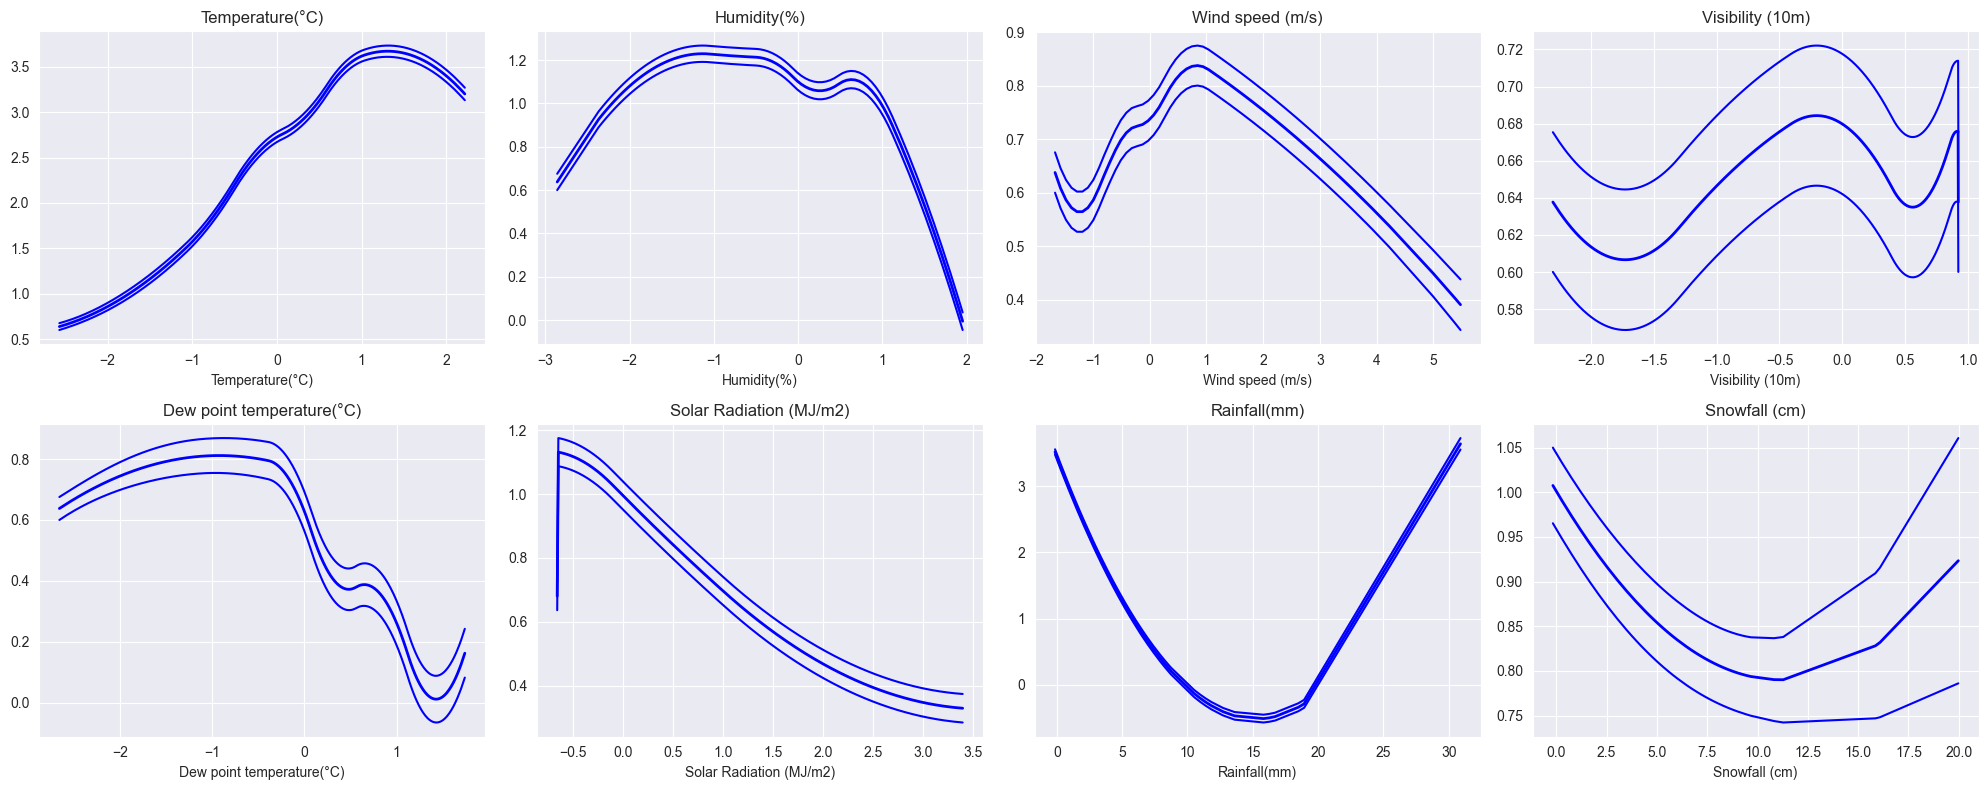

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for i in range(len(X_train_smooth.columns)):
    gam_result.plot_partial(i, ax=axs[i])
    axs[i].set_title(X_train_smooth.columns[i])

# Hide any extra axes
for j in range(len(X_train_smooth.columns), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
png_path = "gam_partial_effects.png"
plt.savefig(png_path, dpi=300)
plt.show()

